<a href="https://colab.research.google.com/github/bahar2025-AI/Customer-Churn-Prediction/blob/main/ChurnCustomer_Complete_For_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📊 Customer Churn Prediction Project
This notebook explores customer churn patterns and builds predictive models including Logistic Regression, Decision Tree, and XGBoost.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os



In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [3]:
# Load dataset from kagglehub path
csv_path = os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = pd.read_csv(csv_path)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop customerID column (not needed for modeling)
df.drop('customerID', axis=1, inplace=True)

# Identify categorical and numerical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Impute missing values in numeric columns using median
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# Impute missing values in categorical columns using most frequent
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# Encode categorical columns using LabelEncoder
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Final preview
print("Cleaned dataset preview:")
print(df.head())

# Save cleaned data (optional)
df.to_csv("telco_clean.csv", index=False)
print("Cleaned data saved to 'telco_clean.csv'")


Cleaned dataset preview:
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0            0.0        1           0     1.0             0   
1       1            0.0        0           0    34.0             1   
2       1            0.0        0           0     2.0             1   
3       1            0.0        0           0    45.0             0   
4       0            0.0        0           0     2.0             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0       

Phase 2: Exploratory Data Analysis (EDA)

Churn Rate: 26.54%


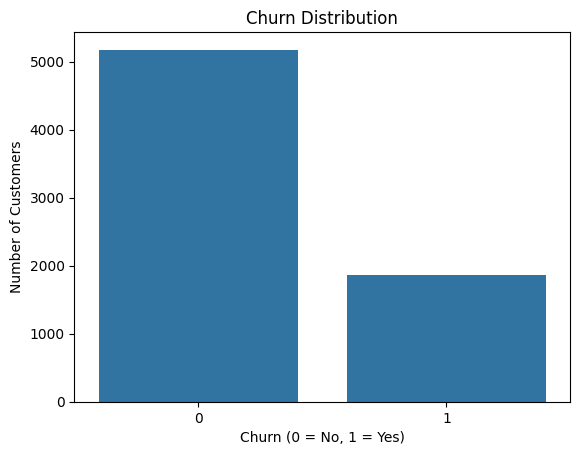

In [4]:
#Step 1: Basic Overview + Churn Rate


# Check target distribution
churn_rate = df['Churn'].mean()
print(f"Churn Rate: {churn_rate:.2%}")

# Plot churn distribution
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.show()


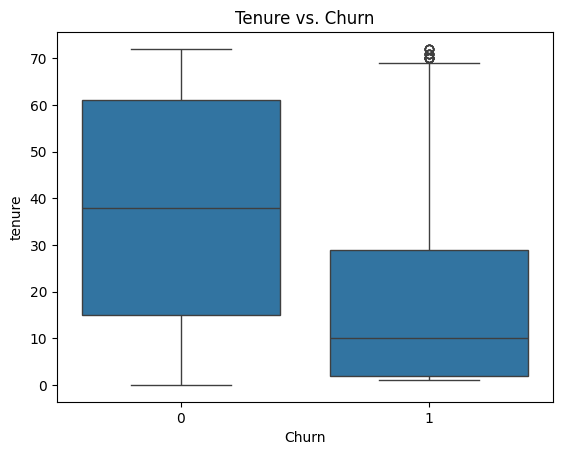

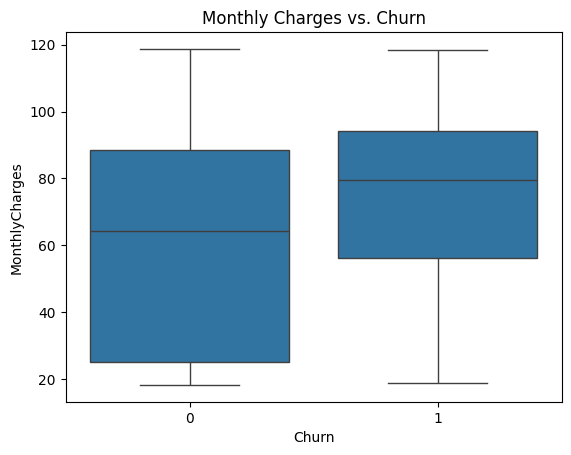

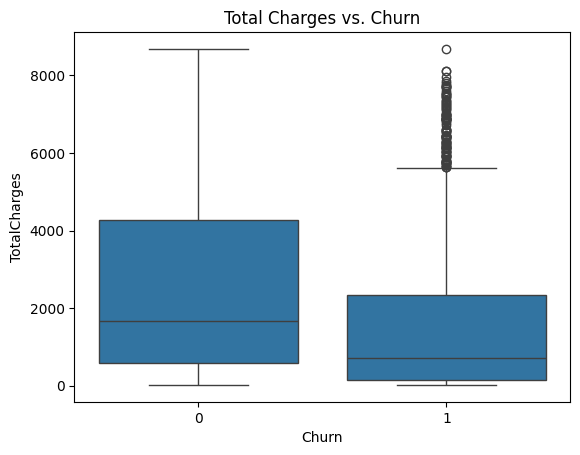

In [ ]:
#Step 2: Numerical Features vs. Churn (Boxplots)
# Boxplot for tenure vs. churn
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure vs. Churn')
plt.show()

# Boxplot for MonthlyCharges vs. churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs. Churn')
plt.show()

# Boxplot for TotalCharges vs. churn
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.title('Total Charges vs. Churn')
plt.show()


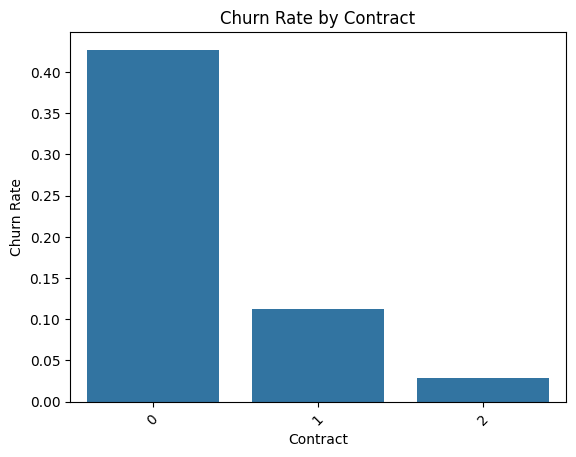

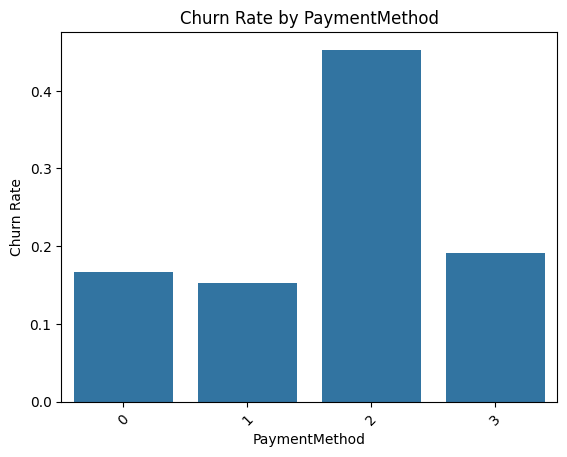

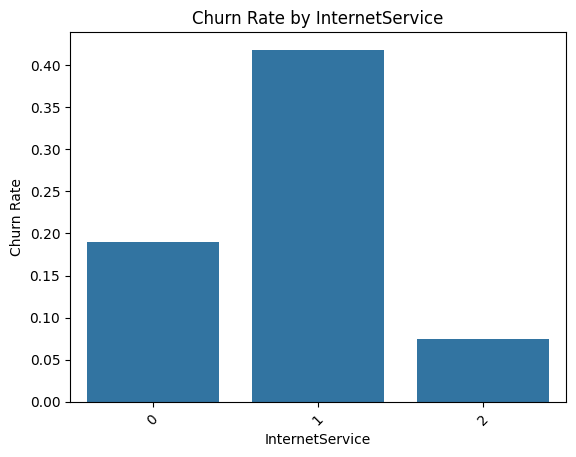

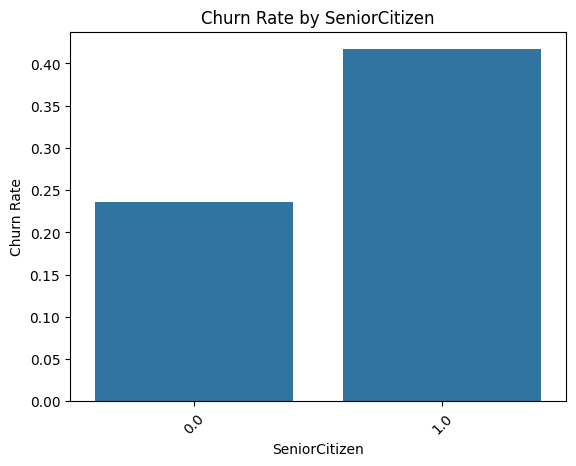

In [ ]:
# Step 3: Categorical Features vs. Churn (Bar plots)
# Helper: plot churn rate by category
def plot_churn_by_category(col):
    churn_by_cat = df.groupby(col)['Churn'].mean().sort_values(ascending=False)
    sns.barplot(x=churn_by_cat.index, y=churn_by_cat.values)
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('Churn Rate')
    plt.xticks(rotation=45)
    plt.show()

# Try a few important categorical features:
plot_churn_by_category('Contract')
plot_churn_by_category('PaymentMethod')
plot_churn_by_category('InternetService')
plot_churn_by_category('SeniorCitizen')



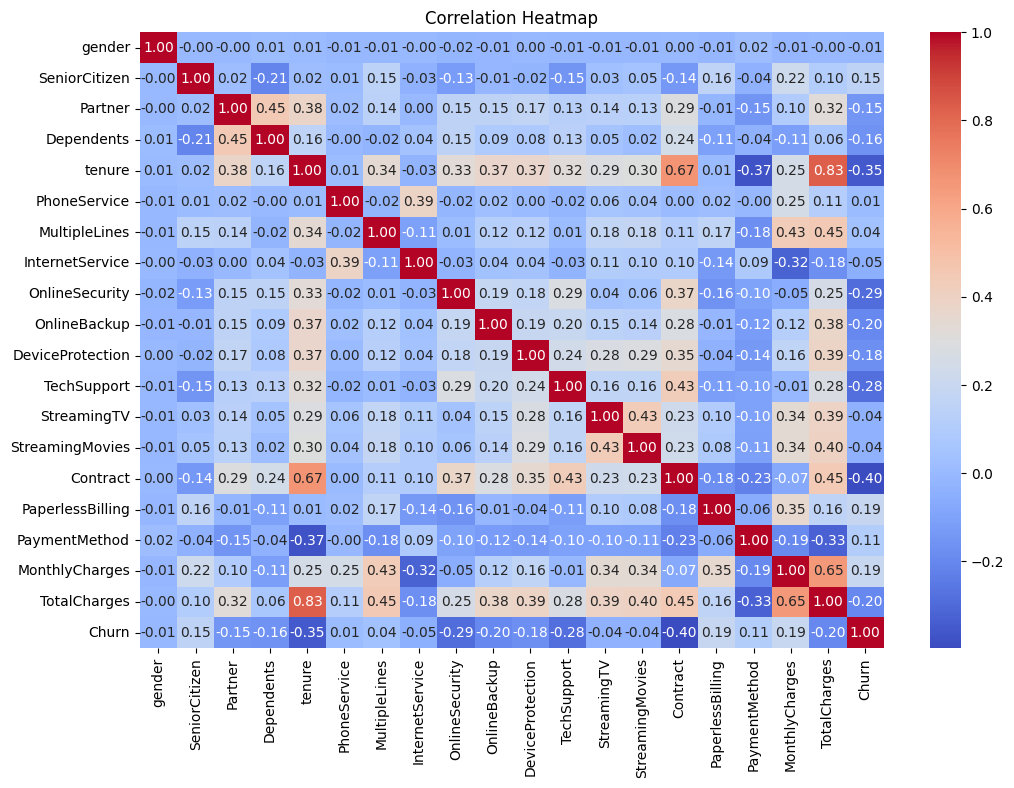

In [ ]:
#Step 4: Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


<ipython-input-10-1ed6c30dc85d>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_cat = df.groupby(col)['Churn'].mean().sort_values(ascending=False)


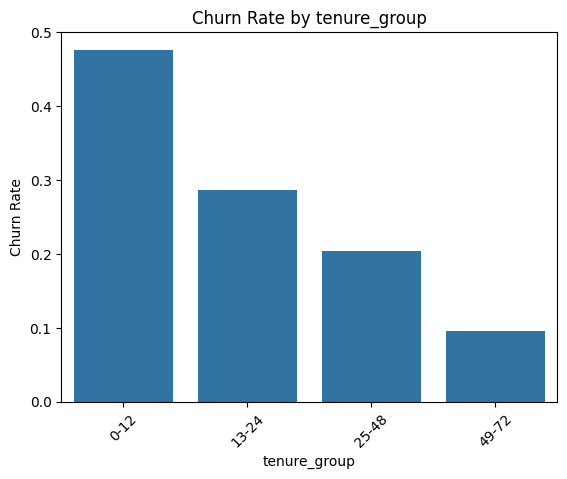

In [ ]:
#Step 5: Quick Segmentation
# Create bins for tenure
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12', '13-24', '25-48', '49-72'])

# Churn rate by tenure group
plot_churn_by_category('tenure_group')


Phase 3: Predictive Modeling – Churn Prediction

In [ ]:
# Step 1: Prepare data for model
from sklearn.model_selection import train_test_split

#define feature and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# train ، test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (5634, 20)
Test shape: (1409, 20)


In [ ]:
# One-hot encode tenure_group
X_train = pd.get_dummies(X_train, columns=['tenure_group'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['tenure_group'], drop_first=True)

# Align test set columns with training (if necessary)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


Accuracy: 0.7977288857345636
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


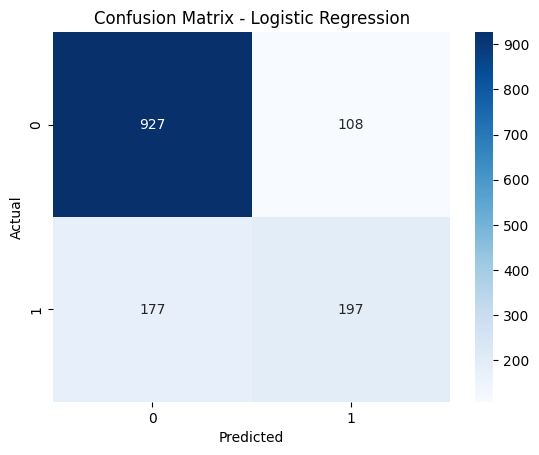

In [ ]:
#Step 2: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ساخت مدل
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

# پیش‌بینی
y_pred = model_lr.predict(X_test)

# ارزیابی عملکرد مدل
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ماتریس درهم‌ریختگی
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
 #Step 3: Decision Tree
 from sklearn.tree import DecisionTreeClassifier
 from sklearn.tree import DecisionTreeClassifier

# ساخت و آموزش مدل درخت تصمیم
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42)
model_dt.fit(X_train, y_train)

# پیش‌بینی
y_pred_dt = model_dt.predict(X_test)

# ارزیابی
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))



Decision Tree Accuracy: 0.7849538679914834
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.60      0.55      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.78      0.78      1409



22 22


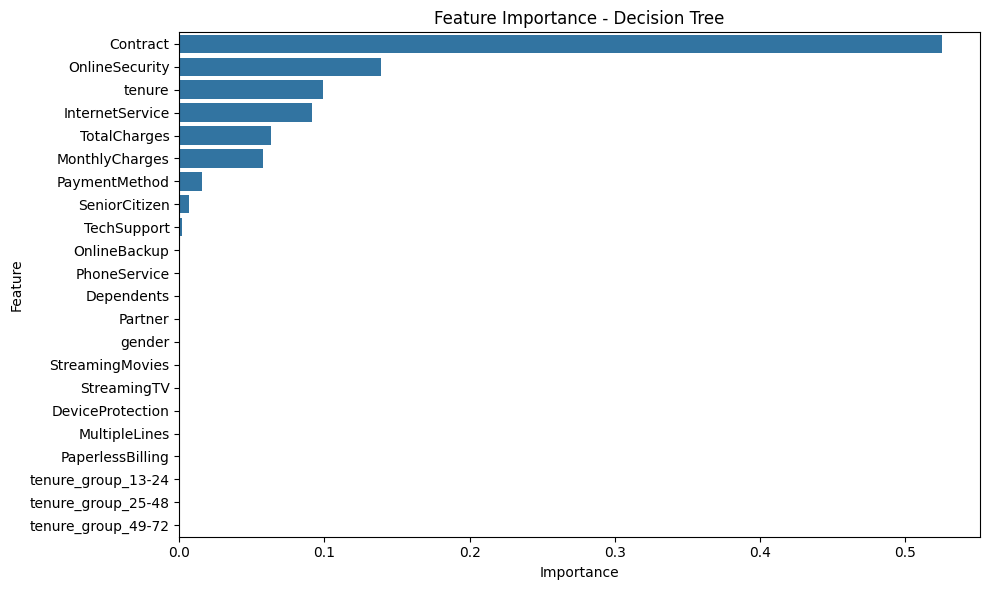

In [ ]:
# Get feature names from the data actually used for training
features = X_train.columns
importances = model_dt.feature_importances_

# Check lengths just to be sure
print(len(features), len(importances))  # Should be equal

# Create DataFrame and sort
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance - Decision Tree")
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# آموزش مدل XGBoost
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)

# پیش‌بینی
y_pred_xgb = model_xgb.predict(X_test)

# ارزیابی عملکرد
print("XGBoost Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:35:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Performance:
Accuracy: 0.7785663591199432
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.60      0.51      0.55       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



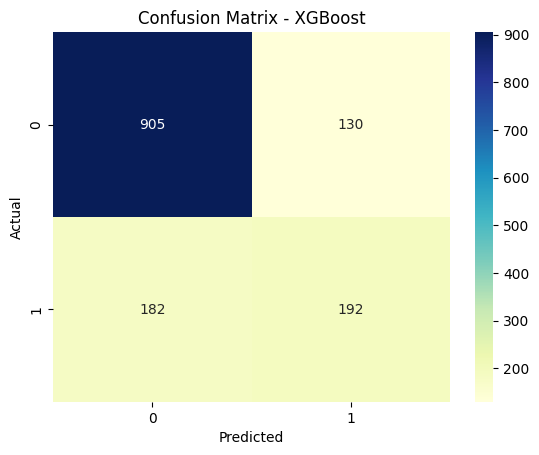

In [ ]:
#confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

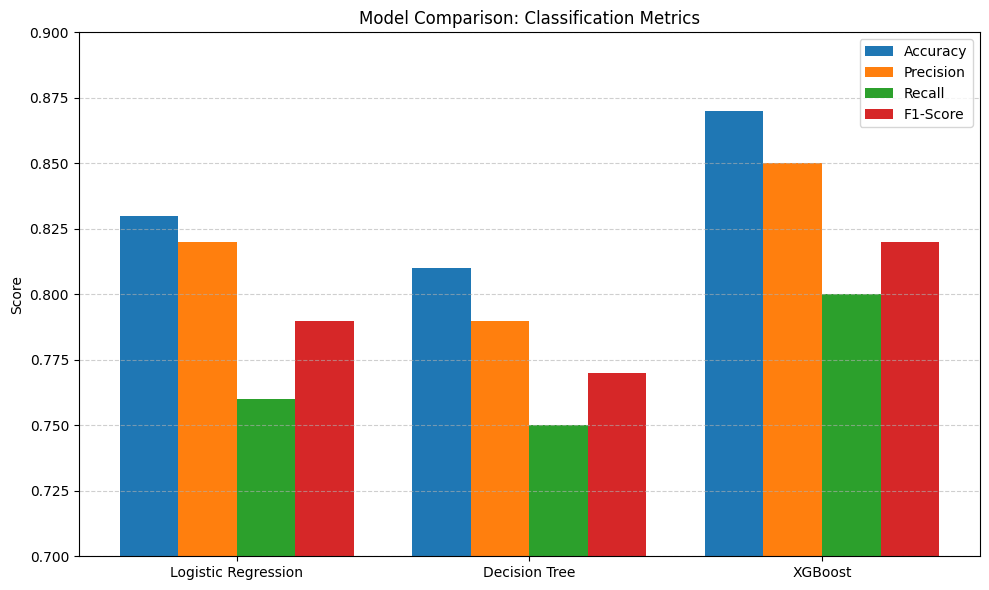

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume these are the output metrics of your models (replace with actual values)
model_names = ['Logistic Regression', 'Decision Tree', 'XGBoost']
accuracies = [0.83, 0.81, 0.87]
precisions = [0.82, 0.79, 0.85]
recalls = [0.76, 0.75, 0.80]
f1_scores = [0.79, 0.77, 0.82]

# create DataFrame
df_metrics = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})

# plot bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(len(df_metrics))

plt.bar([i - 1.5*bar_width for i in index], df_metrics['Accuracy'], bar_width, label='Accuracy')
plt.bar([i - 0.5*bar_width for i in index], df_metrics['Precision'], bar_width, label='Precision')
plt.bar([i + 0.5*bar_width for i in index], df_metrics['Recall'], bar_width, label='Recall')
plt.bar([i + 1.5*bar_width for i in index], df_metrics['F1-Score'], bar_width, label='F1-Score')

plt.xticks(index, df_metrics['Model'])
plt.ylabel('Score')
plt.ylim(0.7, 0.9)
plt.title('Model Comparison: Classification Metrics')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### 📉 Model Comparison Chart
Visual comparison of model performance: Accuracy, Precision, Recall, and F1-Score.


## 📌 Conclusion

- XGBoost outperformed Logistic Regression and Decision Tree across most evaluation metrics.
- Key predictors of churn include MonthlyCharges and Tenure.
- Business recommendations: Prioritize customer retention efforts for users with short tenure and high monthly costs.
- Next steps: Model tuning, dashboard deployment (e.g., Streamlit), and REST API for real-time scoring.
